In [ ]:
!pip3 install imageio==2.4.1

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

replace Actions/train/Walking/person01_walking_d1_uncomp.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset downloaded successfully!!


In [ ]:
import keras
from keras import models
from keras import layers
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
import os, glob
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"

In [ ]:
!rm -r /content/Train_frames
!rm -r /content/Test_frames

In [ ]:
def mse(imageA, imageB):
    # Compute the mean squared error between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def video_capturing_function(data_dir, folder_new):
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            for video_name in os.listdir(folder_path):
                if video_name.endswith(".avi"):
                    video_read_path = os.path.join(folder_path, video_name)
                    cap = cv2.VideoCapture(video_read_path)

                    frame_dir_path = os.path.join(folder_new, folder_name)
                    if not os.path.exists(frame_dir_path):
                        os.makedirs(frame_dir_path)

                    train_write_file = os.path.join(frame_dir_path, video_name.split(".")[0])
                    if not os.path.exists(train_write_file):
                        os.makedirs(train_write_file)

                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    skip_frames = 0
                    capture_frames = 10
                    frameRate = max(1, (frame_count - skip_frames) // capture_frames)

                    count = 0
                    last_frame = None
                    while cap.isOpened() and count < capture_frames:
                        frame_index = skip_frames + frameRate * count
                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                        ret, frame = cap.read()
                        if not ret:
                            break

                        frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                        if last_frame is not None:
                            if mse(frame_grey, last_frame) < 1.0:  # Threshold for frame similarity
                                continue  # Skip similar frame

                        last_frame = frame_grey.copy()

                        filename = "frame%d.jpg" % count
                        cv2.imwrite(os.path.join(train_write_file, filename), frame_grey)
                        count += 1

                    cap.release()

    return print("Done - All frames written in the Folder")

In [ ]:
video_capturing_function(data_dir, "/content/Train_frames")
video_capturing_function(test_data_dir, "/content/Test_frames")

Done - All frames written in the Folder
Done - All frames written in the Folder


In [ ]:
!zip -r /content/Train_frames.zip /content/Train_frames/
!zip -r /content/Test_frames.zip /content/Test_frames/

#### Visualize the frames and analyze the object in each frame by plotting the frames of each class per row (6 rows)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def visualize_frames(data_dir):
    classes = os.listdir(data_dir)
    fig, axes = plt.subplots(len(classes), 6, figsize=(10, 6))  # 6 frames per class row

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        video_folders = os.listdir(class_path)
        frames_to_plot = []

        # Collecting frames from different videos of the class

        for video_folder in video_folders:
            video_frames_path = os.path.join(class_path, video_folder)
            frames = os.listdir(video_frames_path)
            frames = sorted(frames)[:10]  # Take the first 6 frames of each video

            for frame in frames:
                frame_path = os.path.join(video_frames_path, frame)
                img = cv2.imread(frame_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                frames_to_plot.append(img)

            if len(frames_to_plot) >= 6:
                break

        # Plotting the frames
        for j in range(6):
            axes[i, j].imshow(frames_to_plot[j])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.show()

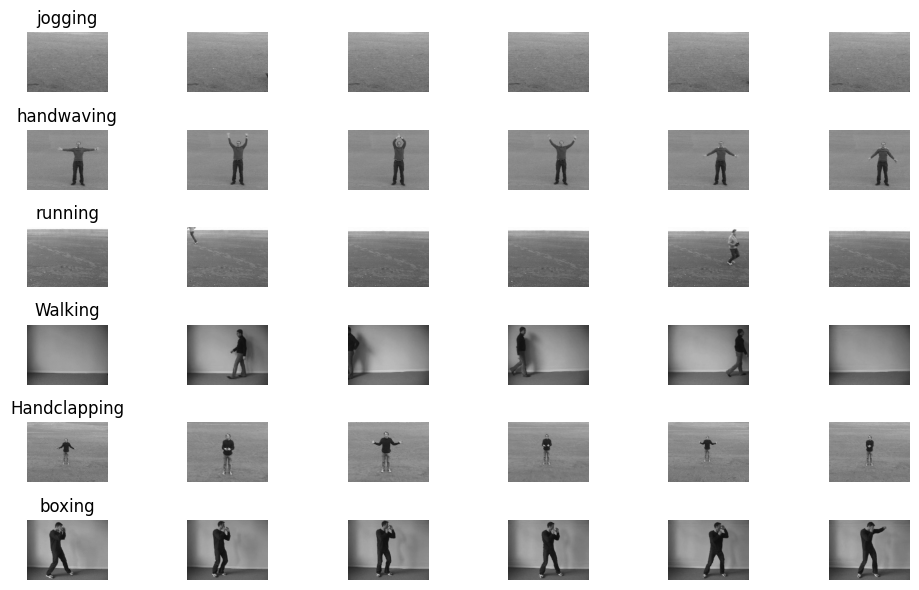

In [ ]:
data_dir = "/content/Train_frames/"
visualize_frames(data_dir)

In [ ]:
from PIL import Image

In [ ]:
no_frames = 10

def data_load_function_10frames(directory):
    frames = []
    actionlabels = []

    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        print(f"now at:", folder_path) # check if iterating across all folders?
        if os.path.isdir(folder_path):
            for subfolder_name in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder_name)
                if os.path.isdir(subfolder_path):

                    # Initialize a list for video data for each subfolder

                    vid_data = []
                    for l in range(no_frames):
                        frame_file = 'frame%d.jpg' % l
                        frame_path = os.path.join(subfolder_path, frame_file)
                        if os.path.exists(frame_path):
                            image = Image.open(frame_path)
                            image = image.resize((80, 80), Image.ANTIALIAS)
                            datu = np.asarray(image)
                            normu_dat = datu / 255
                            vid_data.append(normu_dat)

                    # Append the video data to the frames list if it contains 10 frames

                    if len(vid_data) == no_frames:
                        frames.append(np.array(vid_data))
                        actionlabels.append(folder_name)
    return np.array(frames), np.array(actionlabels)

In [ ]:
train_dir_path="/content/Train_frames"
train_dataset_new, train_labels = data_load_function_10frames(train_dir_path)

now at: /content/Train_frames/jogging


<ipython-input-163-a002050e3ea6>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((80, 80), Image.ANTIALIAS)


now at: /content/Train_frames/handwaving
now at: /content/Train_frames/running
now at: /content/Train_frames/Walking
now at: /content/Train_frames/Handclapping
now at: /content/Train_frames/boxing


In [ ]:
print(train_dataset_new.shape, train_labels.shape)

(478, 10, 80, 80) (478,)


In [ ]:
test_dir_path="/content/Test_frames"
test_dataset_new, test_labels = data_load_function_10frames(test_dir_path)

now at: /content/Test_frames/jogging
now at: /content/Test_frames/handwaving


<ipython-input-163-a002050e3ea6>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((80, 80), Image.ANTIALIAS)


now at: /content/Test_frames/running
now at: /content/Test_frames/Walking
now at: /content/Test_frames/Handclapping
now at: /content/Test_frames/boxing


In [ ]:
print(test_dataset_new.shape, test_labels.shape)

(120, 10, 80, 80) (120,)


### Create the Neural Network 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
model_cnlst = models.Sequential()
model_cnlst.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', strides=(1,1)), input_shape=(10, 80, 80, 1)))
model_cnlst.add(layers.TimeDistributed(layers.BatchNormalization()))
model_cnlst.add(layers.TimeDistributed(layers.MaxPooling2D(2, 2)))

model_cnlst.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')))
model_cnlst.add(layers.TimeDistributed(layers.BatchNormalization()))
model_cnlst.add(layers.TimeDistributed(layers.MaxPooling2D(2, 2)))

model_cnlst.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')))
model_cnlst.add(layers.TimeDistributed(layers.BatchNormalization()))
model_cnlst.add(layers.TimeDistributed(layers.MaxPooling2D(2, 2)))

# Flatten and dropout
model_cnlst.add(layers.TimeDistributed(layers.Flatten()))
model_cnlst.add(layers.Dropout(0.2))

model_cnlst.add(LSTM(128,return_sequences=False,dropout=0.2)) # used 32 units <1>


# Dense layers
model_cnlst.add(layers.Dense(64, activation='relu'))
model_cnlst.add(layers.Dropout(0.2))

model_cnlst.add(layers.Dense(32, activation='relu'))
model_cnlst.add(layers.Dropout(0.2))

# Output layer
model_cnlst.add(layers.Dense(6, activation='softmax'))

model_cnlst.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_70 (TimeD  (None, 10, 78, 78, 128)   1280      
 istributed)                                                     
                                                                 
 time_distributed_71 (TimeD  (None, 10, 78, 78, 128)   512       
 istributed)                                                     
                                                                 
 time_distributed_72 (TimeD  (None, 10, 39, 39, 128)   0         
 istributed)                                                     
                                                                 
 time_distributed_73 (TimeD  (None, 10, 39, 39, 64)    73792     
 istributed)                                                     
                                                                 
 time_distributed_74 (TimeD  (None, 10, 39, 39, 64)  

In [ ]:
#convert train_labels and test_labels to OHE

class_names = ['boxing', 'running', 'Handclapping', 'jogging', 'Walking', 'handwaving']
class_to_int = {class_name: i for i, class_name in enumerate(class_names)}
train_labels_int = np.array([class_to_int[label] for label in train_labels])
num_labels = train_labels_int.shape[0]
num_classes = 6
oh_train_labels = np.zeros((num_labels, num_classes))
oh_train_labels[np.arange(num_labels), train_labels_int] = 1

In [ ]:
test_labels_int = np.array([class_to_int[label] for label in test_labels])
num_labels = test_labels_int.shape[0]
num_classes = 6
oh_test_labels = np.zeros((num_labels, num_classes))
oh_test_labels[np.arange(num_labels), test_labels_int] = 1

In [ ]:
from keras import optimizers

# callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
# monitor='val_loss',patience=10), keras.callbacks.ModelCheckpoint(filepath='cnn_lstm_model_new3.h5',monitor='val_loss', save_best_only=True)]

optimizer_new=optimizers.Nadam(learning_rate=1e-2, name='Nadam')

model_cnlst.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['AUC'])

history_new_cnlst=model_cnlst.fit(train_dataset_new,oh_train_labels,batch_size=8,epochs=20,
                        validation_data=(test_dataset_new,oh_test_labels),
                       callbacks=callbacks_list_cnlst)

Epoch 1/20
60/60 [==============================] - 7s 45ms/step - loss: 1.7553 - auc: 0.5889 - val_loss: 1.9608 - val_auc: 0.5008
Epoch 2/20
60/60 [==============================] - 2s 28ms/step - loss: 1.5365 - auc: 0.7339 - val_loss: 2.4174 - val_auc: 0.5245
Epoch 3/20
60/60 [==============================] - 2s 28ms/step - loss: 1.3701 - auc: 0.7894 - val_loss: 2.7375 - val_auc: 0.4920
Epoch 4/20
60/60 [==============================] - 2s 28ms/step - loss: 1.2705 - auc: 0.8138 - val_loss: 3.1975 - val_auc: 0.5047
Epoch 5/20
60/60 [==============================] - 2s 28ms/step - loss: 1.1969 - auc: 0.8343 - val_loss: 3.6983 - val_auc: 0.4989
Epoch 6/20
60/60 [==============================] - 2s 28ms/step - loss: 1.1866 - auc: 0.8304 - val_loss: 2.4944 - val_auc: 0.5941
Epoch 7/20
60/60 [==============================] - 2s 28ms/step - loss: 1.1137 - auc: 0.8567 - val_loss: 1.4030 - val_auc: 0.7636
Epoch 8/20
60/60 [==============================] - 2s 28ms/step - loss: 1.1320 - a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 2s 28ms/step - loss: 0.7318 - auc: 0.9423 - val_loss: 1.0970 - val_auc: 0.8722
Epoch 19/20
60/60 [==============================] - 2s 28ms/step - loss: 0.7489 - auc: 0.9381 - val_loss: 1.1131 - val_auc: 0.8695
Epoch 20/20
60/60 [==============================] - 2s 28ms/step - loss: 0.6614 - auc: 0.9529 - val_loss: 1.0526 - val_auc: 0.8816


Check confusion matrix, class-wise

Text(0.5, 1.0, 'Training and Test AUC')

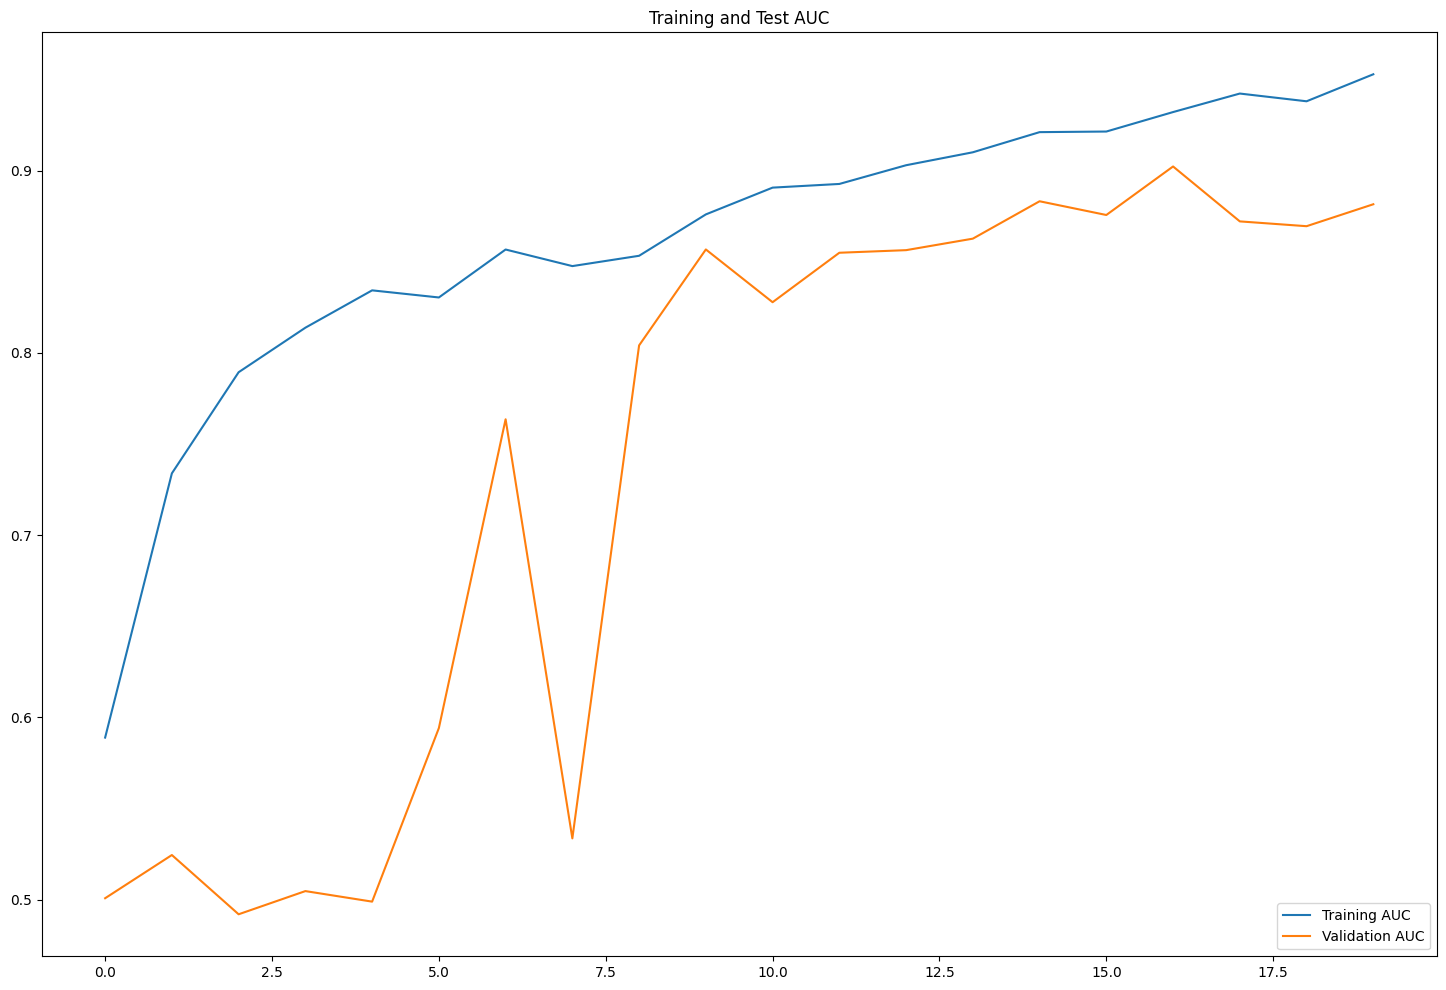

In [ ]:
executed_epochs = len(history_new_cnlst.history['loss'])

auc = history_new_cnlst.history['auc']
val_auc = history_new_cnlst.history['val_auc']

epochs_range = range(executed_epochs)

plt.figure(figsize=(18, 12))
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Test AUC')

Keras Tuner to tune CNN-LSTM model

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner
from keras_tuner import HyperParameters

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # First Conv2D layer
    model.add(TimeDistributed(Conv2D(
        hp.Int("conv_units_1", min_value=320, max_value=512, step=64),
        (3, 3), activation='relu', strides=(1, 1)),
        input_shape=(10, 100, 80, 1)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(2, 2)))

    # Second Conv2D layer
    model.add(TimeDistributed(Conv2D(
        hp.Int("conv_units_2", min_value=64, max_value=256, step=64),
        (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(2, 2)))

    # Third Conv2D layer
    model.add(TimeDistributed(Conv2D(
        hp.Int("conv_units_3", min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(2, 2)))

    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(hp.Float('Dropout_rate1',min_value=0,max_value=0.5,step=0.1)))

    # LSTM layer
    model.add(LSTM(
        hp.Int("lstm_units", min_value=64, max_value=128, step=32),
        return_sequences=False, dropout=0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(hp.Float('Dropout_rate2',min_value=0,max_value=0.5,step=0.1)))

    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Learning rate
    learning_rate = hp.Float("lr", min_value=1e-7, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
)

In [ ]:
tuner.search(train_dataset_new, oh_train_labels, batch_size = 2, epochs=20, validation_data=(test_dataset_new,oh_test_labels))

Trial 20 Complete [00h 03m 26s]
val_accuracy: 0.4750000089406967

Best val_accuracy So Far: 0.6583333313465118
Total elapsed time: 01h 05m 23s


In [ ]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 98, 78, 320)   3200      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 98, 78, 320)   1280      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 49, 39, 320)   0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 49, 39, 128)   368768    
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 49, 39, 128)   5

In [ ]:
# Get the top hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best hyperparameters are: {best_hps.values}")

The best hyperparameters are: {'conv_units_1': 320, 'conv_units_2': 128, 'conv_units_3': 128, 'Dropout_rate1': 0.2, 'lstm_units': 96, 'Dropout_rate2': 0.0, 'lr': 0.00010077872683004541}


### Use pre-trained model for feature extraction

In [ ]:
!rm -r /content/Train_VGG
!rm -r /content/Test_VGG

In [ ]:
def mse(imageA, imageB):
    # Compute the mean squared error between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def frame_capture_function(data_dir, folder_new):
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            for video_name in os.listdir(folder_path):
                if video_name.endswith(".avi"):
                    video_read_path = os.path.join(folder_path, video_name)
                    cap = cv2.VideoCapture(video_read_path)

                    frame_dir_path = os.path.join(folder_new, folder_name)
                    if not os.path.exists(frame_dir_path):
                        os.makedirs(frame_dir_path)

                    train_write_file = os.path.join(frame_dir_path, video_name.split(".")[0])
                    if not os.path.exists(train_write_file):
                        os.makedirs(train_write_file)

                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    skip_frames = 0
                    capture_frames = 10
                    frameRate = max(1, (frame_count - skip_frames) // capture_frames)

                    count = 0
                    last_frame = None
                    while cap.isOpened() and count < capture_frames:
                        frame_index = skip_frames + frameRate * count
                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                        ret, frame = cap.read()
                        if not ret:
                            break

                        frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                        if last_frame is not None:
                            if mse(frame_grey, last_frame) < 1.0:  # Threshold for frame similarity
                                continue  # Skip similar frame

                        last_frame = frame_grey.copy()

                        filename = "frame%d.jpg" % count
                        cv2.imwrite(os.path.join(train_write_file, filename), frame_grey)
                        count += 1

                    cap.release()

    return print("Done - All frames written in the Folder")

In [ ]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"

In [ ]:
video_capturing_function(data_dir, "/content/Train_VGG")
video_capturing_function(test_data_dir, "/content/Test_VGG")

Done - All frames written in the Folder
Done - All frames written in the Folder


In [ ]:
from PIL import Image

In [ ]:
no_frames = 10

def data_load_function_10frames(directory):
    frames = []
    actionlabels = []

    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        print(f"now at:", folder_path) # check if iterating across all folders?
        if os.path.isdir(folder_path):
            for subfolder_name in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder_name)
                if os.path.isdir(subfolder_path):

                    # Initialize a list for video data for each subfolder

                    vid_data = []
                    for l in range(no_frames):
                        frame_file = 'frame%d.jpg' % l
                        frame_path = os.path.join(subfolder_path, frame_file)
                        if os.path.exists(frame_path):
                            image = Image.open(frame_path)
                            image = image.resize((80, 100), Image.ANTIALIAS)
                            datu = np.asarray(image)
                            normu_dat = datu / 255
                            vid_data.append(normu_dat)

                    # Append the video data to the frames list if it contains 10 frames

                    if len(vid_data) == no_frames:
                        frames.append(np.array(vid_data))
                        actionlabels.append(folder_name)
    return np.array(frames), np.array(actionlabels)

In [ ]:
train_dir_path="/content/Train_VGG"
test_dir_path="/content/Test_VGG"
train_dataset_VGG, train_labels_VGG = data_load_function_10frames(train_dir_path)
test_dataset_VGG, test_labels_VGG = data_load_function_10frames(test_dir_path)

In [ ]:
print(train_dataset_VGG.shape, test_dataset_VGG.shape)

(478, 10, 100, 80) (120, 10, 100, 80)


In [ ]:
print(train_labels_VGG.shape, test_labels_VGG.shape)

(478,) (120,)


In [ ]:
# convert train_labels and test_labels to OHE

class_names = ['boxing', 'running', 'Handclapping', 'jogging', 'Walking', 'handwaving']
class_to_int = {class_name: i for i, class_name in enumerate(class_names)}
train_labels_int = np.array([class_to_int[label] for label in train_labels_VGG])
num_labels = train_labels_int.shape[0]
num_classes = 6
ohe_train_labels = np.zeros((num_labels, num_classes))
ohe_train_labels[np.arange(num_labels), train_labels_int] = 1

In [ ]:
test_labels_int = np.array([class_to_int[label] for label in test_labels_VGG])
num_labels = test_labels_int.shape[0]
num_classes = 6
ohe_test_labels = np.zeros((num_labels, num_classes))
ohe_test_labels[np.arange(num_labels), test_labels_int] = 1

In [ ]:
print(ohe_train_labels.shape, ohe_test_labels.shape)

(478, 6) (120, 6)


In [ ]:
train_data_rgb = np.repeat(train_dataset_VGG[..., np.newaxis], 3, -1)
test_data_rgb = np.repeat(test_dataset_VGG[..., np.newaxis], 3, -1)
train_data_rgb.shape, test_data_rgb.shape

((478, 10, 100, 80, 3), (120, 10, 100, 80, 3))

In [ ]:
num_classes = 6

def create_model():
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 80, 3))
    vgg16.trainable = False  # Freeze VGG16 layers

    model = Sequential()
    model.add(TimeDistributed(vgg16, input_shape=(10, 100, 80, 3)))  # 10 frames per video
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(1200, return_sequences=False))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))  # num_classes should be the number of actions

    optimizers.RMSprop(learning_rate=1e-5, name="rmsprop")



    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#### Load and fine-tune the pre-trained model

In [ ]:
# Initialize the model
check_point = keras.callbacks.ModelCheckpoint("VGG_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model = create_model()
model.fit(train_data_rgb, ohe_train_labels, batch_size=4, epochs=50, validation_data=(test_data_rgb, ohe_test_labels), callbacks=[check_point])

Epoch 1/50
118/120 [============================>.] - ETA: 0s - loss: 1.6391 - accuracy: 0.3453
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to VGG_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 6s 33ms/step - loss: 1.6337 - accuracy: 0.3452 - val_loss: 1.1217 - val_accuracy: 0.3333
Epoch 2/50
118/120 [============================>.] - ETA: 0s - loss: 1.0548 - accuracy: 0.4831
Epoch 2: val_accuracy improved from 0.33333 to 0.50000, saving model to VGG_model.h5
120/120 [==============================] - 3s 28ms/step - loss: 1.0604 - accuracy: 0.4791 - val_loss: 0.9140 - val_accuracy: 0.5000
Epoch 3/50
118/120 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.5614
Epoch 3: val_accuracy improved from 0.50000 to 0.53333, saving model to VGG_model.h5
120/120 [==============================] - 3s 29ms/step - loss: 0.8821 - accuracy: 0.5628 - val_loss: 0.9078 - val_accuracy: 0.5333
Epoch 4/50
118/120 [============================>.] - ETA: 0s - loss: 0.7474 - accuracy: 0.6610
Epoch 4: val_accuracy did not improve from 0.53333
120/120 [==============================] - 3s 23ms/step - loss: 0.7444 - accuracy: 0.6632 - val

In [ ]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_112 (Time  (None, 10, 3, 2, 512)     14714688  
 Distributed)                                                    
                                                                 
 time_distributed_113 (Time  (None, 10, 3072)          0         
 Distributed)                                                    
                                                                 
 lstm_40 (LSTM)              (None, 1200)              20510400  
                                                                 
 dense_81 (Dense)            (None, 1024)              1229824   
                                                                 
 dropout_30 (Dropout)        (None, 1024)              0         
                                                                 
 dense_82 (Dense)            (None, 6)               

In [ ]:
predictions = model.predict(test_data_rgb, batch_size = 1)

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(oh_test_labels, axis=1)

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=['boxing', 'running', 'Handclapping', 'jogging', 'Walking', 'handwaving'])
print(report)

              precision    recall  f1-score   support

      boxing       1.00      0.85      0.92        20
     running       0.59      0.65      0.62        20
Handclapping       0.65      0.55      0.59        20
     jogging       0.29      0.25      0.27        20
     Walking       0.67      0.70      0.68        20
  handwaving       0.54      0.70      0.61        20

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.62       120
weighted avg       0.62      0.62      0.62       120



<Axes: >

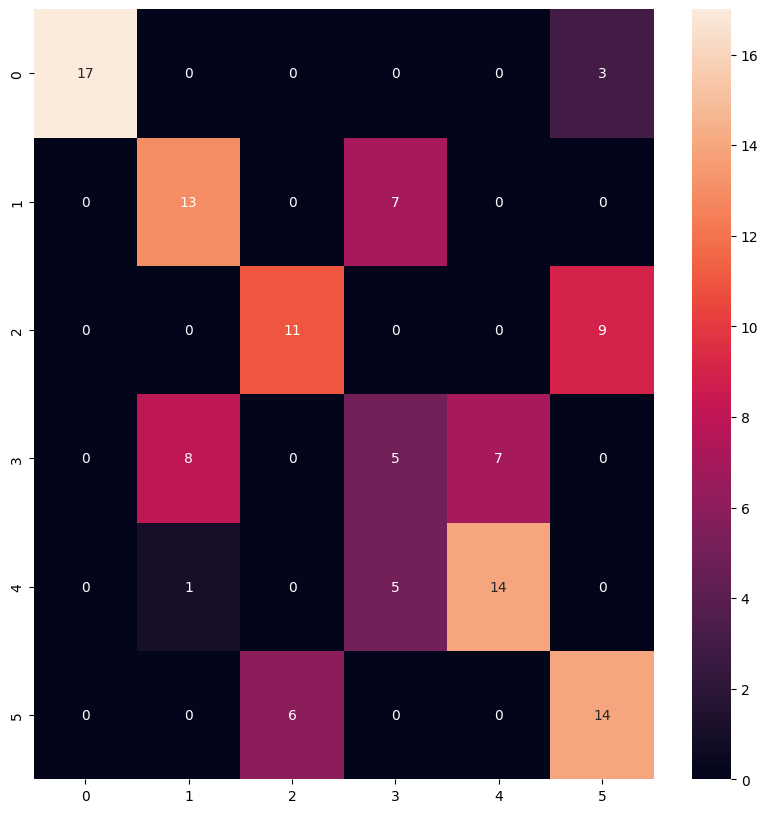

In [ ]:
cf = confusion_matrix(true_classes, predicted_classes)

df_cm = pd.DataFrame(cf)
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)